<h2 style="color:#1C3C5C";>Noise measurement on the DC lines using the ADwin</h2>

<h3 style="color:#418FDB";>Imports</h3>
Import the functions used in the measurement.

In [102]:
# test adwin

import sys
import os
import datetime
import time
import requests 
import tqdm.notebook as tqdm

import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm


cm_plot = cm.get_cmap('tab10')



<h3 style="color:#418FDB";>QCodes imports and drivers</h3>
Import the QCodes functions and drivers.

In [104]:
import qcodes as qc
from qcodes.logger.logger import start_all_logging
from qcodes.instrument.parameter import Parameter
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Drivers')

from ADwin_Gold2 import ADwin_Gold2, ADwin_ramp

ADwin_Gold2.close_all()

ad = ADwin_Gold2("adwin",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\ADwin11.btl",
                 r"C:\Users\nicolas.roch\Measurements\Drivers\adwin\nanoqt\ressources\acquisition-gold2.TB1")


def get_temp():
    """Getting the temperature from the iMacRT"""
    r = requests.get('http://192.168.0.5/WebGet')
    jj = r.json()
    return float(jj[3]['X'])

Connected to: None adwin (serial:None, firmware:None) in 0.25s


<h3 style="color:#418FDB";>Setting up the measurement</h3>
We reuse the ramp functionnality of the driver but without any output. The total duration of the measurement here is $4\times 1$ seconds with around 4000 samples per seconds. This should give us a good (but non exact) idea of the noise spectrum between $0.2$ Hz and $4$ kHz.

In [105]:
ad.input_mask(0b1)
ad.output_mask(0b1)
# ad.adwin_mode(0b0)
ad.clear_fifos()
ad.go_to_zero()
ramp_param = ADwin_ramp("dc_noise_4seconds2", 
                        ad, 
                        period=1, 
                        n_pts=40000,
                        N_ramp=4,
                        Vs_high=np.array([0, 0]),
                        Vs_low=np.array([0,0]))

We also acquire the temperature of the fridge by querying the iMacRT

In [106]:
def get_temp():
    r = requests.get('http://192.168.0.7/WebGet')
    jj = r.json()
    return float(jj[3]['X'])

print("Test run for the temperature; Temp= %.2f K" % get_temp() )

temp = Parameter('T2_3',
                  label='Temperature',
                  unit='K',
                  get_cmd=lambda: get_temp())

Test run for the temperature; Temp= 0.02 K


<h3 style="color:#418FDB";>Test run</h3>

In [107]:
u = time.time()
data_ad1 = ramp_param()
print('Total estimated duration of the measurement: %.3f s' % ( time.time()-u) ) 

Total estimated duration of the measurement: 5.713 s


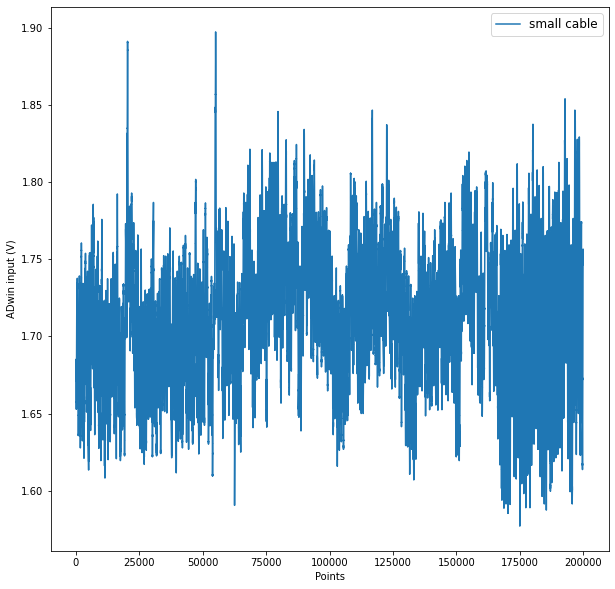

In [108]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.plot(data_ad0[0, :], label='long cable')
ax.plot(data_ad1[0, :], label='small cable')
# ax.plot(data_ad2[0, :], label='input 1- 50Hz filter', color=cm_plot(1))
ax.legend(fontsize='large')
ax.set_ylabel('ADwin input (V)')
ax.set_xlabel('Points')
plt.show()

In [109]:
f_noise0 = np.fft.fft(data_ad0, axis=1)
f_noise1 = np.fft.fft(data_ad1, axis=1)
# f_noise2=np.fft.fft(data_ad2, axis=1)

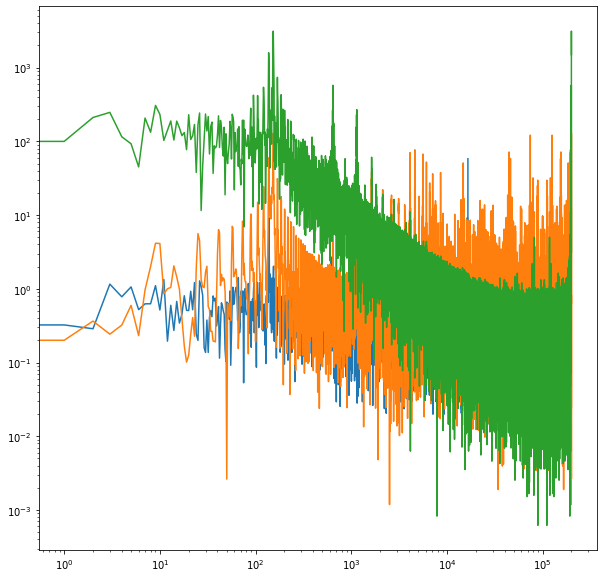

In [110]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
# ax1= fig.add_subplot(122)
ax0.loglog(np.abs(f_noise[0, 100:]), label='ref')
ax0.loglog(np.abs(f_noise0[0, 100:]))
ax0.loglog(np.abs(f_noise1[0, 100:]))

# ax0.loglog(np.abs(f_noise2[0]))
# ax0.loglog(np.abs(f_noise[-1]))
#ax0.set_xlim([1,1e3])

<h3 style="color:#418FDB";>QCodes database setup</h3>

In [112]:

start_all_logging()

# Create a station
station = qc.Station()
station.add_component(ad)

station.snapshot()
station.components

# Experiment details
date=datetime.datetime.today().strftime('%Y_%m_%d')
exp_name='noise_dc_lines_adwin'
sample_name = 'dc_lines_warming_up'

database_name = date+"_"+exp_name

# script_dir=os.path.dirname(__file__)
data_dir=os.path.join(r'C:\Users\nicolas.roch\Measurements\Experiments\dc_noise')

try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

data_dir=data_dir + '\\' +exp_name

try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

DB_PATH = data_dir+'\\'+database_name
qc.initialise_or_create_database_at(DB_PATH)
qc.config.core.db_location

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


2021-12-02 16:31:54,233 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: outputs
2021-12-02 16:31:54,233 ¦ qcodes.instrument.base ¦ WARNING ¦ base ¦ snapshot_base ¦ 259 ¦ [adwin(ADwin_Gold2)] Snapshot: Could not update parameter: inputs


Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\211202-12596-qcodes.log


'C:\\Users\\nicolas.roch\\Measurements\\Experiments\\dc_noise\\noise_dc_lines_adwin\\2021_12_02_noise_dc_lines_adwin'

In [113]:

exp=qc.load_or_create_experiment(experiment_name=exp_name,
                          sample_name=sample_name)

<h3 style="color:#418FDB";>Continuous measurement for 10 hour every 15 min</h3>

In [ ]:
meas = qc.Measurement(exp=exp, station=station)
meas.register_parameter(temp)
meas.register_parameter(ramp_param, setpoints=[temp])
meas.write_period = 10

with meas.run() as datasaver:
    for i in tqdm.tqdm(range(10*4)):
        noise_pts = ramp_param()
        measured_temp = temp()
        datasaver.add_result((temp, measured_temp),(ramp_param, noise_pts))
        time.sleep(60*15)

Starting experimental run with id: 1. 


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]

In [13]:
1+1

2